In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
import seaborn as sns
from itertools import product
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora

In [9]:
df = pd.read_csv('../assets/creditcard.csv')

In [4]:
df.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# summarize the class distribution
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

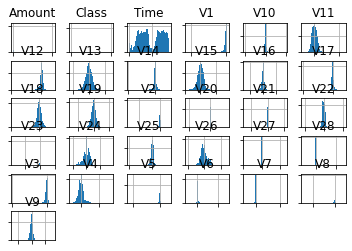

In [11]:
# create histograms of input variables
from pandas import read_csv
from matplotlib import pyplot
# define the dataset location
filename = '../assets/creditcard.csv'
# load the csv file as a data frame
dataframe = read_csv(filename, header=None)

# drop the target variable
df.drop(df.columns[30], axis=1)
# create a histogram plot of each numeric variable
ax = df.hist(bins=100)
# disable axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
# show the plot
pyplot.show()

We can see that the distribution of most of the PCA components is Gaussian, and many may be centered around zero, suggesting that the variables were standardized as part of the PCA transform.

In [12]:
df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Model Test and Baseline Result

In [15]:
# test harness and baseline model evaluation for the credit dataset
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

# load the dataset
def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    # retrieve numpy array
    data = data.values
    # split into input and output elements
    X, y = data[:, :30], data[:, 30]
    return X, y

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
    # calculate precision-recall curve
    p, r, _ = precision_recall_curve(y_true, probas_pred)
    # calculate area under curve
    return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define the location of the dataset
full_path = '../assets/creditcard.csv'
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

(284808, 30) (284808,) Counter({0: 251650, '0': 32665, 1: 390, '1': 102, 'Class': 1})


TypeError: '<' not supported between instances of 'int' and 'str'